In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
%matplotlib inline

In [2]:
# Define log pattern
log_pattern = (
    r'(?P<ip>\S+) '                  # IP address
    r'\S+ \S+ '                      # Remote logname and user (ignored)
    r'\[(?P<time>.+?)\] '            # Timestamp
    r'"(?P<request>.*?)" '           # Request line
    r'(?P<status>\d{3}) '            # Status code
    r'(?P<size>\S+) '                # Response size
    r'"(?P<referer>.*?)" '           # Referer
    r'"(?P<user_agent>.*?)"'         # User agent
)

In [ ]:
import os
print(os.getcwd())
os.chdir('/Users/abhishekkandel/Desktop/LOG Analysis/')
print(os.getcwd())

/Users/abhishekkandel/Desktop/LOG Analysis
/Users/abhishekkandel/Desktop/LOG Analysis


In [7]:
chunk_size = 10000
df_list = []

def parse_log_line(line):
    match = re.match(log_pattern, line)
    if match:
        return match.groupdict()
    else:
        return None

with open('access.log', 'r', encoding='utf-8', errors='ignore') as file:
    batch = []
    for idx, line in enumerate(file):
        parsed_line = parse_log_line(line)
        if parsed_line:
            batch.append(parsed_line)
        if (idx + 1) % chunk_size == 0:
            temp_df = pd.DataFrame(batch)
            df_list.append(temp_df)
            batch = []
    if batch:
        temp_df = pd.DataFrame(batch)
        df_list.append(temp_df)

In [5]:
# Read and Parse the Log File Efficiently
chunk_size = 10000  
df_list = []

with open('access.log', 'r', encoding='utf-8', errors='ignore') as file:
    batch = []
    for idx, line in enumerate(file):
        parsed_line = parse_log_line(line)
        if parsed_line:
            batch.append(parsed_line)
        if (idx + 1) % chunk_size == 0:
            temp_df = pd.DataFrame(batch)
            df_list.append(temp_df)
            batch = []
    if batch:
        temp_df = pd.DataFrame(batch)
        df_list.append(temp_df)

# Concatenate all DataFrame chunks
df = pd.concat(df_list, ignore_index=True)

FileNotFoundError: [Errno 2] No such file or directory: 'access.log'

In [ ]:
# Handeling Any Parsing Errors
print(df.isnull().sum())

NameError: name 'df' is not defined

In [ ]:
# Extract Method, URL, and Protocol
request_pattern = r'^(?P<method>\S+)\s+(?P<url>\S+)\s+(?P<protocol>HTTP/\d\.\d)$'

# Use str.extract to apply the pattern
df[['method', 'url', 'protocol']] = df['request'].str.extract(request_pattern, expand=True)

In [ ]:
# Missing Values After Extraction 
missing_data = df[df['method'].isnull() | df['url'].isnull() | df['protocol'].isnull()]
print(f"Number of incomplete entries: {len(missing_data)}")

Number of incomplete entries: 287


In [ ]:
df = df.dropna(subset=['method', 'url', 'protocol'])

In [ ]:
# Perform Basic Analysis

In [ ]:
# Convert Data Types
# Convert 'time' to datetime
df['time'] = pd.to_datetime(df['time'], format='%d/%b/%Y:%H:%M:%S %z')

# Convert 'status' to integer
df['status'] = df['status'].astype(int)

# Convert 'size' to integer, replacing '-' with 0
df['size'] = df['size'].replace('-', 0).astype(int)

In [ ]:
# 1. Top IP Addresses
top_ips = df['ip'].value_counts().head(20)
print("Top IP Addresses:")
print(top_ips)

Top IP Addresses:
ip
66.249.66.194      353483
66.249.66.91       314522
151.239.241.163     92473
66.249.66.92        88332
91.99.30.32         45973
104.222.32.91       42058
91.99.72.15         38694
91.99.47.57         38609
5.78.190.233        37203
195.181.168.181     27979
23.101.169.3        27800
195.181.168.164     24044
66.249.66.93        22146
17.58.102.43        21698
104.222.32.94       16706
5.160.157.20        13526
5.117.116.238       13422
5.160.221.38        12058
172.20.2.174        11303
40.77.167.156       10231
Name: count, dtype: int64


In [ ]:
#  Most Requested URLs
top_urls = df['url'].value_counts().head(20)
print("\nMost Requested URLs:")
print(top_urls)


Most Requested URLs:
url
/settings/logo                                                                                                             352047
/static/css/font/wyekan/font.woff                                                                                          280176
/static/images/guarantees/bestPrice.png                                                                                    138010
/static/images/guarantees/fastDelivery.png                                                                                 125689
/static/images/guarantees/warranty.png                                                                                     124127
/static/images/guarantees/goodShopping.png                                                                                 116653
/site/alexaGooleAnalitic                                                                                                   103798
/favicon.ico                                                    

In [ ]:
#  HTTP Status Codes Distribution
status_counts = df['status'].value_counts()
print("\nHTTP Status Codes Distribution:")
print(status_counts)


HTTP Status Codes Distribution:
status
200    9579824
304     340228
302     199835
404     105011
301      67552
499      50852
500      14266
403       5634
502        798
401        323
400        318
408        112
504        103
405          6
206          3
Name: count, dtype: int64


In [ ]:
#  URLs Resulting in 404 Errors
errors_404 = df[df['status'] == 404]
top_404_urls = errors_404['url'].value_counts().head(20)
print("\nTop URLs Resulting in 404 Errors:")
print(top_404_urls)


Top URLs Resulting in 404 Errors:
url
/apple-touch-icon-precomposed.png                                                            17836
/apple-touch-icon.png                                                                        16786
/apple-touch-icon-120x120.png                                                                13217
/apple-touch-icon-120x120-precomposed.png                                                    13217
/product/themes/default-rtl/style.css                                                          959
/product/falsedefault-rtl/style.css                                                            821
/apple-touch-icon-152x152.png                                                                  763
/apple-touch-icon-152x152-precomposed.png                                                      760
/m/alexaGooleAnalitic                                                                          660
/static/plugins/ckeditor-3.6.2.2/js/ckeditor/contents.min.css         

In [ ]:
# Traffic Over Time
# Requests per day
df['date'] = df['time'].dt.date
requests_per_day = df.groupby('date').size()
print("\nRequests per Day:")
print(requests_per_day)


Requests per Day:
date
2019-01-22    2160886
2019-01-23    2328468
2019-01-24    1857801
2019-01-25    1843257
2019-01-26    2174453
dtype: int64


In [ ]:
#  Visualize the Results

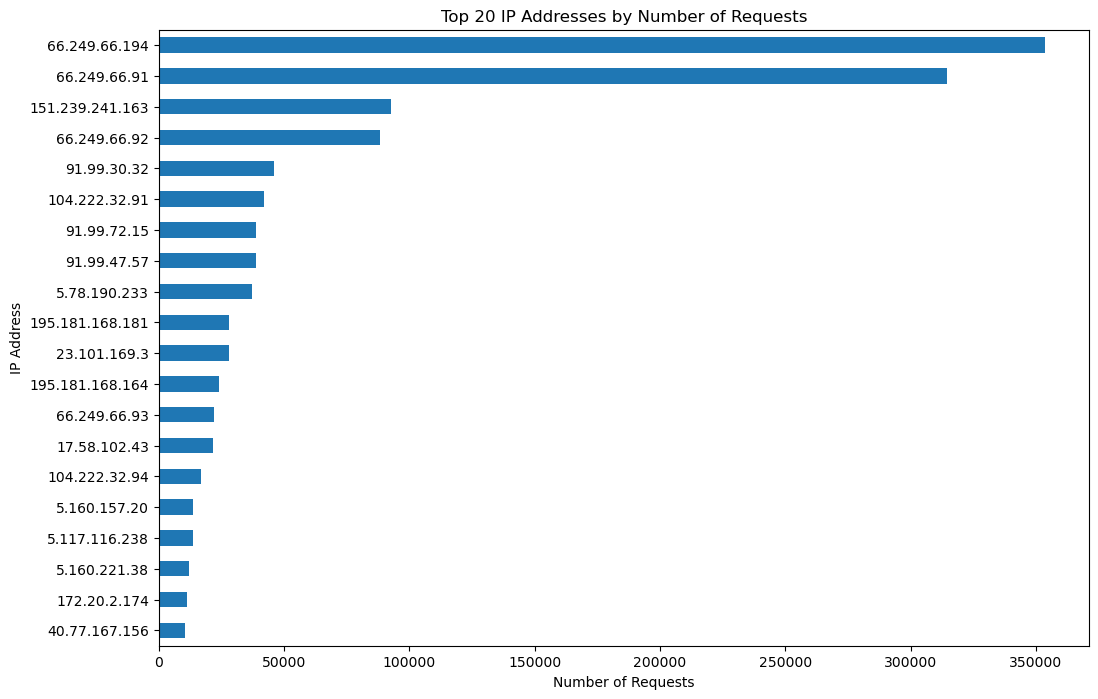

In [ ]:
# Plot Top IP Addresses
top_ips.plot(kind='barh', figsize=(12,8))
plt.xlabel('Number of Requests')
plt.ylabel('IP Address')
plt.title('Top 20 IP Addresses by Number of Requests')
plt.gca().invert_yaxis()
plt.show()

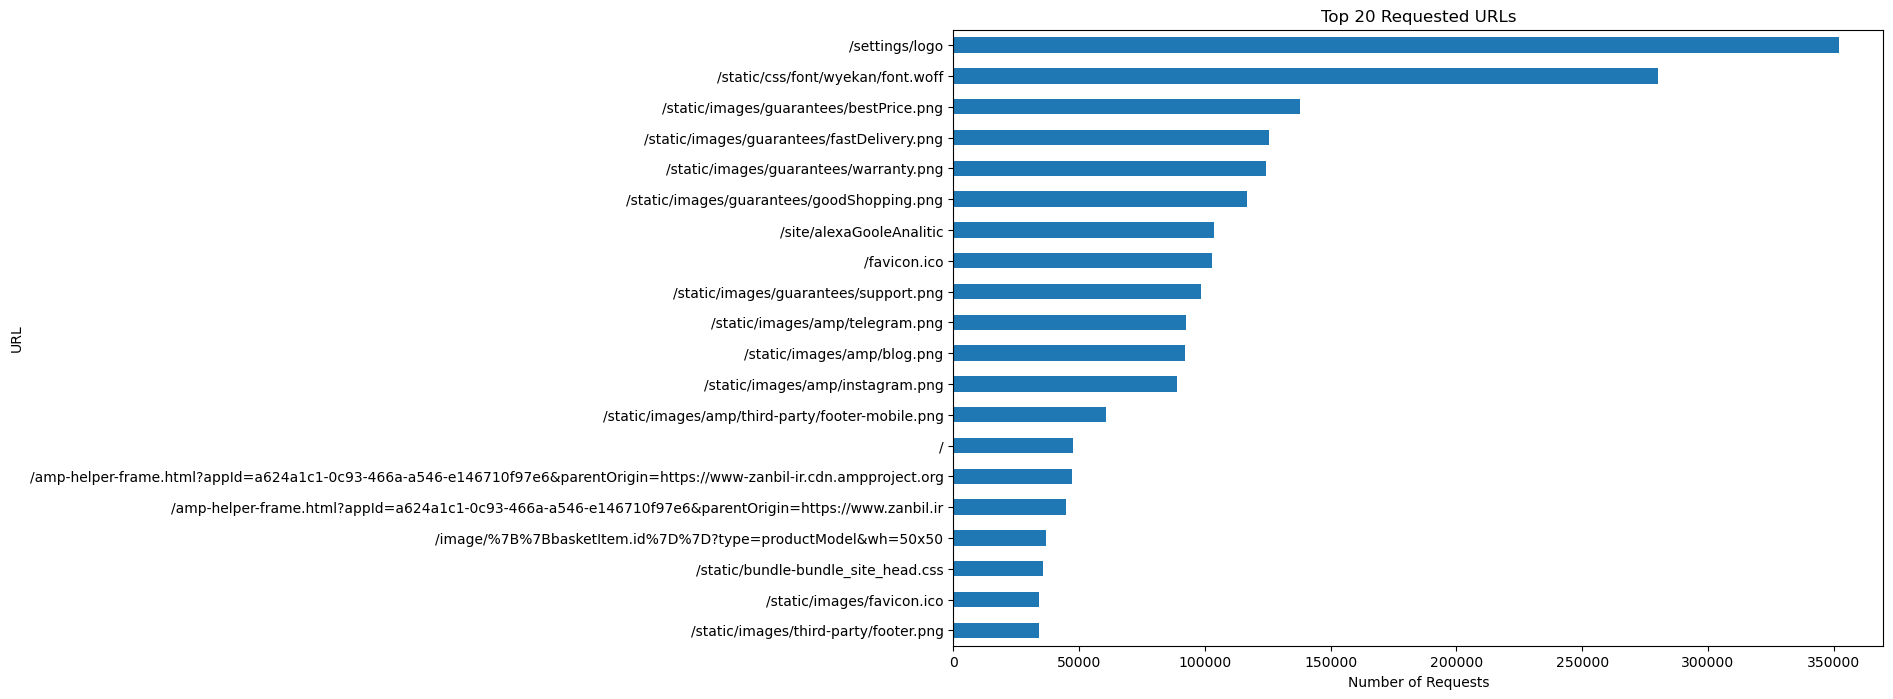

In [ ]:
# Plot Most Requested URLs

top_urls.plot(kind='barh', figsize=(12,8))
plt.xlabel('Number of Requests')
plt.ylabel('URL')
plt.title('Top 20 Requested URLs')
plt.gca().invert_yaxis()
plt.show()


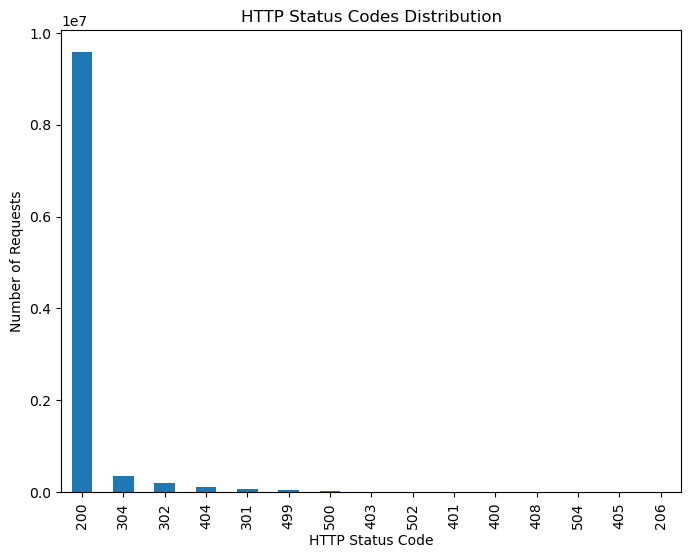

In [ ]:
#  Plot HTTP Status Codes Distribution
status_counts.plot(kind='bar', figsize=(8,6))
plt.xlabel('HTTP Status Code')
plt.ylabel('Number of Requests')
plt.title('HTTP Status Codes Distribution')
plt.show()

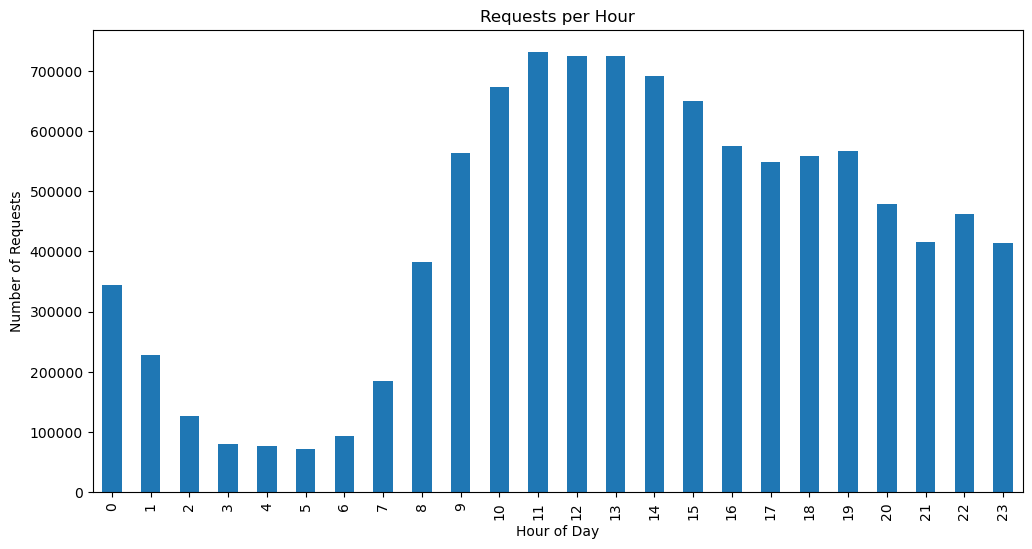

In [ ]:
# Requests per Hour
df['hour'] = df['time'].dt.hour
requests_per_hour = df.groupby('hour').size()
requests_per_hour.plot(kind='bar', figsize=(12,6))
plt.xlabel('Hour of Day')
plt.ylabel('Number of Requests')
plt.title('Requests per Hour')
plt.show()

In [ ]:
#  User Agent Analysis
top_user_agents = df['user_agent'].value_counts().head(10)
print("Top User Agents:")
print(top_user_agents)

Top User Agents:
user_agent
Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/71.0.3578.98 Safari/537.36                                                                                        746572
Mozilla/5.0 (Windows NT 6.1; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/71.0.3578.98 Safari/537.36                                                                                         702672
Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/71.0.3578.98 Safari/537.36                                                                                                     636897
Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:64.0) Gecko/20100101 Firefox/64.0                                                                                                                            552142
Mozilla/5.0 (Windows NT 6.1; rv:64.0) Gecko/20100101 Firefox/64.0                                                                       

In [ ]:
# Filter out bot traffic based on user agents
bot_user_agents = [
    'Googlebot', 'bingbot', 'AhrefsBot', 'YandexBot', 'Baiduspider', 'Sogou', 'Exabot', 'facebot', 'ia_archiver'
]
human_traffic = df[~df['user_agent'].str.contains('|'.join(bot_user_agents), case=False, na=False)]

# Analyze the most requested URLs by human traffic
top_human_urls = human_traffic['url'].value_counts().head(20)
print("\nMost Requested URLs by Human Traffic:")
print(top_human_urls)

# Identify the most demanding product
# Assuming product URLs contain '/product/' in their path
product_urls = human_traffic[human_traffic['url'].str.contains('/product/', case=False, na=False)]
top_products = product_urls['url'].value_counts().head(10)
print("\nMost Demanding Products:")
print(top_products)


Most Requested URLs by Human Traffic:
url
/settings/logo                                                                                                             351989
/site/alexaGooleAnalitic                                                                                                   103691
/static/css/font/wyekan/font.woff                                                                                          102777
/favicon.ico                                                                                                               102088
/static/images/guarantees/goodShopping.png                                                                                  99027
/static/images/guarantees/warranty.png                                                                                      98356
/static/images/guarantees/bestPrice.png                                                                                     98099
/static/images/guarantees/fastDelivery.png     